In [2]:
import numpy as np
import pandas as pd
import json
import string

## Load and process review dataset

### 1. Load the dataset into a data frame named products.

In [6]:
products = pd.read_csv('../data/amazon_baby_subset.csv')

### 2. data transformations:
- fill n/a values in the review column with empty strings
- Remove punctuation

In [7]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

translator = str.maketrans('', '', string.punctuation)
def remove_punctuation(text):
    return text.translate(translator) 

products['review_clean'] = products['review'].apply(remove_punctuation)
products.head(3)

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...


### 3. Compute word counts (only for important_words)

In [10]:
with open('../data/important_words.json') as important_words_file:    
    important_words = json.load(important_words_file)
print (important_words[:3])

['baby', 'one', 'great']


In [11]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

### 4. Show 'perfect' word counts

In [13]:
products['perfect'][:3]

0    0
1    0
2    0
Name: perfect, dtype: int64

## Train-Validation split

### 5. split the data into a train-validation split with 80%

In [14]:
with open('../data/module-4-assignment-train-idx.json') as train_data_file:    
    train_data_idx = json.load(train_data_file)
with open('../data/module-4-assignment-validation-idx.json') as validation_data_file:    
    validation_data_idx = json.load(validation_data_file)

print (train_data_idx[:3])
print (validation_data_idx[:3])

[0, 1, 3]
[2, 9, 23]


In [15]:
print (len(train_data_idx))
print (len(validation_data_idx))

42361
10711


In [16]:
train_data = products.iloc[train_data_idx]
train_data.head(2)

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
validation_data = products.iloc[validation_data_idx]
validation_data.head(2)

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Cloth Diaper Pins Stainless Steel Traditional ...,It has been many years since we needed diaper ...,5,1,It has been many years since we needed diaper ...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###  6. Convert train_data and validation_data into multi-dimensional arrays.

Using the function given in #8 of [Module 3 assignment](https://www.coursera.org/learn/ml-classification/supplement/zU6HO/implementing-logistic-regression-from-scratch) or [Programming Assignment 2](https://github.com/SSQ/Coursera-UW-Machine-Learning-Classification/tree/master/Programming%20Assignment%202)

In [18]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.values
    label_sarray = dataframe[label]
    label_array = label_sarray.values
    return(feature_matrix, label_array)

In [19]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

/Users/llchen5/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
print (feature_matrix_train.shape)
print (feature_matrix_valid.shape)

(42361, 194)
(10711, 194)


## Building on logistic regression with no L2 penalty assignment

### 7. Compute predictions given by the link function.
- Take two parameters: feature_matrix and coefficients.
- First compute the dot product of feature_matrix and coefficients.
- Then compute the link function P(y=+1|x,w).
- Return the predictions given by the link function.

In [21]:
'''
feature_matrix: N * D(intercept term included)
coefficients: D * 1
predictions: N * 1
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''

def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix, coefficients) # N * 1
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1.0/(1+np.exp(-score))
    
    # return predictions
    return predictions

##  Adding L2 penalty

### 9. Adding L2 penalty to the derivative
- errors: vector whose i-th value contains
- feature: vector whose i-th value contains
- coefficient: the current value of the j-th coefficient.
- l2_penalty: the L2 penalty constant λ
- feature_is_constant: a Boolean value indicating whether the j-th feature is constant or not.

The function should do the following:

- Take the five parameters as above.
- Compute the dot product of errors and feature and save the result to derivative.
- If feature_is_constant is False, subtract the L2 penalty term from derivative. Otherwise, do nothing.
- Return derivative.

In [23]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    """
    errors: N * 1
    feature: N * 1
    derivative: 1 
    coefficient: 1
    """
    derivative = np.dot(np.transpose(errors), feature)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative = derivative -2 * l2_penalty * coefficient
        
    return derivative

### 1. Quiz question: 
In the code above, was the intercept term regularized?

### 1. Answer:
No

### 10. computing log likelihood  with L2

In [24]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    # scores.shape (53072L, 1L)
    # indicator.shape (53072L,)
    # lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    lp = np.sum((np.transpose(np.array([indicator]))-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

### 2. Quiz question: 
Does the term with L2 regularization increase or decrease ℓℓ(w)?

### 3. Answer:
decrease

### 11. Write a function logistic_regression_with_L2 to fit a logistic regression model under L2 regularization.

The function accepts the following parameters:

- feature_matrix: 2D array of features
- sentiment: 1D array of class labels
- initial_coefficients: 1D array containing initial values of coefficients
- step_size: a parameter controlling the size of the gradient steps
- l2_penalty: the L2 penalty constant λ
- max_iter: number of iterations to run gradient ascent
- The function returns the last set of coefficients after performing gradient ascent.

The function carries out the following steps:

- Initialize vector coefficients to initial_coefficients.
- Predict the class probability P(yi=+1|xi,w) using your predict_probability function and save it to variable predictions.
- Compute indicator value for (yi=+1) by comparing sentiment against +1. Save it to variable indicator.
- Compute the errors as difference between indicator and predictions. Save the errors to variable errors.
- For each j-th coefficient, compute the per-coefficient derivative by calling feature_derivative_L2 with the j-th column of feature_matrix. Don't forget to supply the L2 penalty. Then increment the j-th coefficient by (step_size*derivative).
- Once in a while, insert code to print out the log likelihood.
- Repeat steps 2-6 for max_iter times.

In [26]:
# coefficients: D * 1
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = np.transpose(np.array([indicator])) - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] += step_size*derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print ('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

## Explore effects of L2 regularization

### 12.  train models with different L2
Now that we have written up all the pieces needed for an L2 solver with logistic regression, let's explore the benefits of using L2 regularization while analyzing sentiment for product reviews. As iterations pass, the log likelihood should increase.

Let us train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation. Train 6 models with L2 penalty values 0, 4, 10, 1e2, 1e3, and 1e5. Use the following values for the other parameters:

-  feature_matrix = feature_matrix_train extracted in #7
- sentiment = sentiment_train extracted in #7
- initial_coefficients = a 194-dimensional vector filled with zeros
- step_size = 5e-6
- max_iter = 501

Save the 6 sets of coefficients as coefficients_0_penalty, coefficients_4_penalty, coefficients_10_penalty, coefficients_1e2_penalty, coefficients_1e3_penalty, and coefficients_1e5_penalty respectively.

In [27]:
initial_coefficients = np.zeros((194,1))
step_size = 5e-6
max_iter = 501

In [28]:
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train , sentiment_train , initial_coefficients, step_size, 0, max_iter)

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of observed labels = -27193.8767

In [29]:
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train , sentiment_train , initial_coefficients, step_size, 4, max_iter)

iteration   0: log likelihood of observed labels = -29179.39508175
iteration   1: log likelihood of observed labels = -29003.73417180
iteration   2: log likelihood of observed labels = -28834.71441858
iteration   3: log likelihood of observed labels = -28671.80345068
iteration   4: log likelihood of observed labels = -28514.58077957
iteration   5: log likelihood of observed labels = -28362.69830317
iteration   6: log likelihood of observed labels = -28215.85663259
iteration   7: log likelihood of observed labels = -28073.79071393
iteration   8: log likelihood of observed labels = -27936.26093762
iteration   9: log likelihood of observed labels = -27803.04751805
iteration  10: log likelihood of observed labels = -27673.94684207
iteration  11: log likelihood of observed labels = -27548.76901327
iteration  12: log likelihood of observed labels = -27427.33612958
iteration  13: log likelihood of observed labels = -27309.48101569
iteration  14: log likelihood of observed labels = -27195.0462

In [30]:
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train , sentiment_train , initial_coefficients, step_size, 10, max_iter)

iteration   0: log likelihood of observed labels = -29179.40062984
iteration   1: log likelihood of observed labels = -29003.76654163
iteration   2: log likelihood of observed labels = -28834.79322654
iteration   3: log likelihood of observed labels = -28671.94687528
iteration   4: log likelihood of observed labels = -28514.80571589
iteration   5: log likelihood of observed labels = -28363.02048079
iteration   6: log likelihood of observed labels = -28216.29071186
iteration   7: log likelihood of observed labels = -28074.35036891
iteration   8: log likelihood of observed labels = -27936.95892966
iteration   9: log likelihood of observed labels = -27803.89576265
iteration  10: log likelihood of observed labels = -27674.95647005
iteration  11: log likelihood of observed labels = -27549.95042714
iteration  12: log likelihood of observed labels = -27428.69905549
iteration  13: log likelihood of observed labels = -27311.03455140
iteration  14: log likelihood of observed labels = -27196.7989

In [31]:
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train , sentiment_train , initial_coefficients, step_size, 1e2, max_iter)

iteration   0: log likelihood of observed labels = -29179.48385120
iteration   1: log likelihood of observed labels = -29004.25177457
iteration   2: log likelihood of observed labels = -28835.97382190
iteration   3: log likelihood of observed labels = -28674.09410083
iteration   4: log likelihood of observed labels = -28518.17112932
iteration   5: log likelihood of observed labels = -28367.83774654
iteration   6: log likelihood of observed labels = -28222.77708939
iteration   7: log likelihood of observed labels = -28082.70799392
iteration   8: log likelihood of observed labels = -27947.37595368
iteration   9: log likelihood of observed labels = -27816.54738615
iteration  10: log likelihood of observed labels = -27690.00588850
iteration  11: log likelihood of observed labels = -27567.54970126
iteration  12: log likelihood of observed labels = -27448.98991327
iteration  13: log likelihood of observed labels = -27334.14912742
iteration  14: log likelihood of observed labels = -27222.8604

In [32]:
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train , sentiment_train , initial_coefficients, step_size, 1e3, max_iter)

iteration   0: log likelihood of observed labels = -29180.31606471
iteration   1: log likelihood of observed labels = -29009.07176112
iteration   2: log likelihood of observed labels = -28847.62378912
iteration   3: log likelihood of observed labels = -28695.14439397
iteration   4: log likelihood of observed labels = -28550.95060743
iteration   5: log likelihood of observed labels = -28414.45771129
iteration   6: log likelihood of observed labels = -28285.15124375
iteration   7: log likelihood of observed labels = -28162.56976044
iteration   8: log likelihood of observed labels = -28046.29387744
iteration   9: log likelihood of observed labels = -27935.93902900
iteration  10: log likelihood of observed labels = -27831.15045502
iteration  11: log likelihood of observed labels = -27731.59955260
iteration  12: log likelihood of observed labels = -27636.98108219
iteration  13: log likelihood of observed labels = -27547.01092670
iteration  14: log likelihood of observed labels = -27461.4242

In [33]:
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train , sentiment_train , initial_coefficients, step_size, 1e5, max_iter)

iteration   0: log likelihood of observed labels = -29271.85955115
iteration   1: log likelihood of observed labels = -29271.71006589
iteration   2: log likelihood of observed labels = -29271.65738833
iteration   3: log likelihood of observed labels = -29271.61189923
iteration   4: log likelihood of observed labels = -29271.57079975
iteration   5: log likelihood of observed labels = -29271.53358505
iteration   6: log likelihood of observed labels = -29271.49988440
iteration   7: log likelihood of observed labels = -29271.46936584
iteration   8: log likelihood of observed labels = -29271.44172890
iteration   9: log likelihood of observed labels = -29271.41670149
iteration  10: log likelihood of observed labels = -29271.39403722
iteration  11: log likelihood of observed labels = -29271.37351294
iteration  12: log likelihood of observed labels = -29271.35492661
iteration  13: log likelihood of observed labels = -29271.33809523
iteration  14: log likelihood of observed labels = -29271.3228

## Compare coefficients

### 13. Analysis coefficient without penalty 

In [34]:
coefficients_0_penalty_without_intercept = list(coefficients_0_penalty[1:]) # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(important_words, coefficients_0_penalty_without_intercept)]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)

In [35]:
positive_words = []
for i in range(5):
    positive_words.append(word_coefficient_tuples[:5][i][0])
positive_words

['love', 'loves', 'easy', 'perfect', 'great']

In [36]:
negative_words = []
for i in range(5):
    negative_words.append(word_coefficient_tuples[-5:][i][0])
negative_words

['returned', 'waste', 'return', 'money', 'disappointed']

#### Question 3 Which of the following words is not listed in either positive_words or negative_words?

#### Answer: Quality




### 14.  observe the effect of increasing L2 penalty on the 10 words

In [37]:
table = pd.DataFrame(data=[coefficients_0_penalty.flatten(), coefficients_4_penalty.flatten(), coefficients_10_penalty.flatten(), coefficients_1e2_penalty.flatten(), coefficients_1e3_penalty.flatten(), coefficients_1e5_penalty.flatten()], 
                     index=[0, 4, 10, 100.0, 1000.0, 100000.0],
                     columns=['(intercept)'] + important_words)

In [38]:
table.head(2)

,(intercept),baby,one,great,love,use,would,like,easy,little,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0.0,-0.063742,0.074073,0.012753,0.801625,1.058554,-0.000104,-0.287021,-0.003384,0.984559,0.524419,...,0.058308,-0.196906,-0.277845,0.173191,-0.132197,0.052494,0.004960,-0.166745,-0.031916,-0.228852
4.0,-0.063143,0.073994,0.012495,0.796897,1.050856,0.000163,-0.286027,-0.003442,0.977600,0.521385,...,0.057905,-0.195273,-0.275461,0.171640,-0.131083,0.052130,0.004907,-0.165367,-0.031621,-0.226793


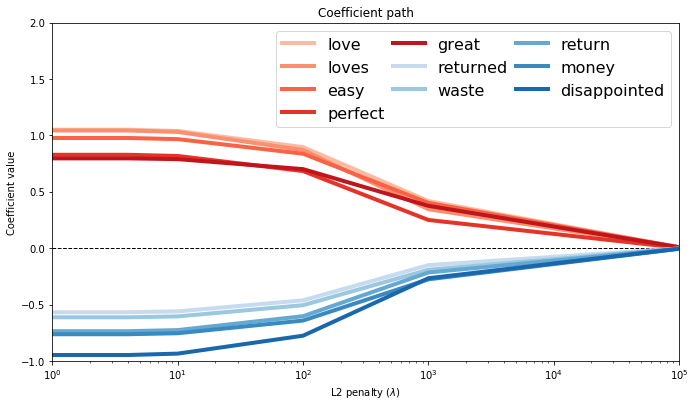

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    
    table_positive_words = table[positive_words] 
    table_negative_words = table[negative_words]
    #del table_positive_words['word']
    #del table_negative_words['word']
    
    for i, value in enumerate(positive_words):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[value].values.flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i, value in enumerate(negative_words):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[value].values.flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])


### 4. Quiz Question: 
(True/False) All coefficients consistently get smaller in size as L2 penalty is increased.

### 4. Answer:
True

##### Question 5
The relative order of coefficients is preserved as the L2 penalty is increased. (For example, if the coefficient for 'cat' was more positive than that for 'dog', this remains true as the L2 penalty increases.)
##### Answer: False


## Measuring accuracy

### 15.  compute the accuracy of the classifier model.

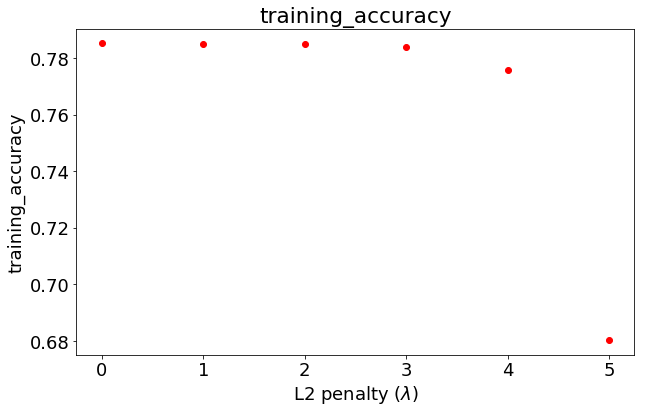

In [41]:
"""
feature_matrix: N * D
coefficients: D * 1
predictions: N * 1
"""
training_accuracy = []
for coefficient in [coefficients_0_penalty, coefficients_4_penalty, coefficients_10_penalty, coefficients_1e2_penalty, coefficients_1e3_penalty, coefficients_1e5_penalty]:
    predictions = predict_probability(feature_matrix_train, coefficient)
    correct_num = np.sum((np.transpose(predictions.flatten())> 0.5) == (np.array(sentiment_train)>0))
    total_num = len(sentiment_train)
    #print "correct_num: {}, total_num: {}".format(correct_num, total_num)
    training_accuracy.append(correct_num * 1./ total_num)
    #print accuracy
l2_penalty_list=[x for x in range(6)]
plt.plot(l2_penalty_list, training_accuracy,'ro')
plt.title('training_accuracy')
plt.xlabel('L2 penalty ($\lambda$)')
plt.ylabel('training_accuracy')
plt.show()

In [42]:
[0, 4, 10, 1e2, 1e3, 1e5][training_accuracy.index(max(training_accuracy))]

0

In [33]:
training_accuracy[training_accuracy.index(max(training_accuracy))]

0.78515615778664338

###  Quiz question 6: 
Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the highest accuracy on the training data?
### Answer:
0

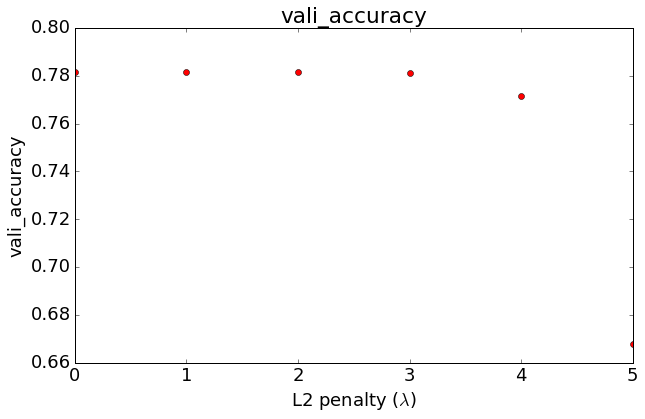

In [34]:
vali_accuracy = []
for coefficient in [coefficients_0_penalty, coefficients_4_penalty, coefficients_10_penalty, coefficients_1e2_penalty, coefficients_1e3_penalty, coefficients_1e5_penalty]:
    predictions = predict_probability(feature_matrix_valid, coefficient)  
    correct_num = np.sum((np.transpose(predictions.flatten())> 0.5) == (np.array(sentiment_valid)>0))
    total_num = len(sentiment_valid)
    #print "correct_num: {}, total_num: {}".format(correct_num, total_num)
    vali_accuracy.append(correct_num * 1./ total_num)
    #print accuracy
l2_penalty_list=[x for x in range(6)]
plt.plot(l2_penalty_list, vali_accuracy,'ro')
plt.title('vali_accuracy')
plt.xlabel('L2 penalty ($\lambda$)')
plt.ylabel('vali_accuracy')
plt.show()                  

In [35]:
[0, 4, 10, 1e2, 1e3, 1e5][vali_accuracy.index(max(vali_accuracy))]

10

In [36]:
vali_accuracy[vali_accuracy.index(max(vali_accuracy))]

0.78171972738306417

### Quiz question 7: 
Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the highest accuracy on the validation  data?
### Answer:
10

### Quiz question 8: 
Does the highest accuracy on the training data imply that the model is the best one?

### Answer: No 

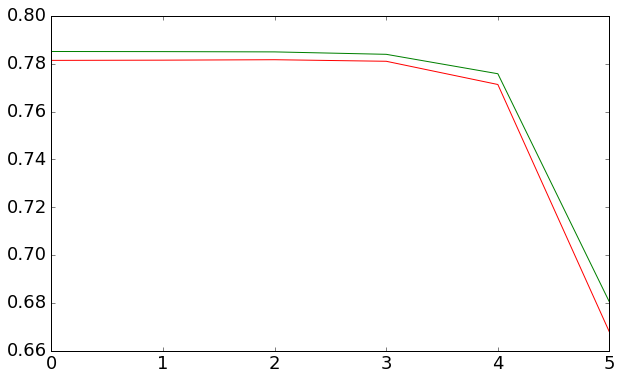

In [37]:
plt.plot(l2_penalty_list, training_accuracy,'g')
plt.plot(l2_penalty_list, vali_accuracy,'r')
